In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 24.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import mne
import json
# from AudioOnsetUtils import *
import tensorflow as tf

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
PNUMs=['01','04','06','07','09','11','12','13','14']

In [ ]:
mega_eeg_list=[]
mega_audio_list=[]
mega_song_id_list = []
for PNUM in PNUMs:
  eeg_dir = "/content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/64_InputChannels/Sub"+PNUM+"/P"+PNUM+"-formatted.json"
  # prediction_dir = "/content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/Testing/64Hz_vlaai_temp/P" + PNUM + '-predictions.json'
  with open(eeg_dir, 'r') as file_x:
    sub_eeg_dict=json.load(file_x)

  mega_eeg_list+= [value for value in sub_eeg_dict.values()]

  file_path = "/content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/audio/pretrained_vlaai_envelope/audio-envelope-formatted.json"
  # os.makedirs(prediction_dir, exist_ok=True)
  with open(file_path, 'r') as file_x:
    env_dict=json.load(file_x)


  for key,value in sub_eeg_dict.items():
    song_id=key.split('_')[1]
    if PNUM in ['01','04','06','07'] and song_id in ['s1','s2','s11','s12','s22']:
      env_key=song_id+'_v1'
    else:
      env_key=song_id+'_v2'
    mega_audio_list.append(env_dict[env_key])
    mega_song_id_list.append(song_id)


In [ ]:
print(len(mega_eeg_list))
print(len(mega_song_id_list))

900
900


In [ ]:
# Simulated EEG data (replace with your actual EEG data)
# EEG_data should be a list of EEG events, where each event is a 2D array with shape (samples, channels)
# In your case, EEG_data is a list of 900 events with shape (618, 64)
# EEG_data is assumed to be arranged by stimuli, so each set of 75 events corresponds to one stimulus
# You should replace this simulated data with your actual EEG data
# num_events_per_stimulus = 75
num_stimuli = 12
num_channels = 64
# EEG_data = [np.random.randn(618, 64) for _ in range(num_events_per_stimulus * num_stimuli)]
EEG_data = mega_eeg_list

In [ ]:
# Preprocess EEG data (you can use more elaborate preprocessing steps)
scaler = StandardScaler()
EEG_data_scaled = [scaler.fit_transform(event) for event in EEG_data]

In [ ]:
#DO NOT RUN
# Feature extraction (you can use your specific feature extraction method)
# pca = PCA(n_components=5)  # PCA as a simplified feature extraction method
# EEG_features = [pca.fit_transform(event) for event in EEG_data_scaled]

In [ ]:
# print(type(EEG_features),len(EEG_features),len(EEG_features[0]),len(EEG_features[0][0]),type(EEG_features[0][0][0]))

In [ ]:
# Define similarity constraints based on stimuli
similar_constraints = []
dissimilar_constraints = []

In [ ]:
for i in range(len(mega_song_id_list)):
  for j in range(i+1,len(mega_song_id_list)):
    if(mega_song_id_list[i]==mega_song_id_list[j]):
      similar_constraints.append((i, j))
    else:
      dissimilar_constraints.append((i,j))

# for i in range(num_stimuli):
#     stimulus_start_idx = i * num_events_per_stimulus
#     for j in range(stimulus_start_idx, stimulus_start_idx + num_events_per_stimulus):
#         for k in range(j + 1, stimulus_start_idx + num_events_per_stimulus):
#             similar_constraints.append((j, k))
#         for l in range(num_events_per_stimulus):
#             if l != j - stimulus_start_idx:
#                 dissimilar_constraints.append((j, l + stimulus_start_idx))

In [ ]:
print(len(similar_constraints))
# print(len(dissimilar_constraints))

33639


In [ ]:
# Create a similarity matrix with constraints
num_samples = len(EEG_data_scaled)
print(num_samples)
similarity_matrix = np.zeros((num_samples, num_samples))

900


In [ ]:
for i, j in similar_constraints:
    similarity_matrix[i, j] = 1  # Similarity constraint
    similarity_matrix[j, i] = 1

# for i, j in dissimilar_constraints:
#     similarity_matrix[i, j] = -1  # Dissimilarity constraint
#     similarity_matrix[j, i] = -1

In [ ]:
print(len(similarity_matrix),len(similarity_matrix[0]), type(similarity_matrix[0][0]))

900 900 <class 'numpy.float64'>


In [ ]:
min_values = np.min(EEG_data_scaled, axis=(0, 1, 2))
max_values = np.max(EEG_data_scaled, axis=(0, 1, 2))
mean_value = np.mean(EEG_data_scaled)
std = np.std(EEG_data_scaled, axis=(0, 1, 2))

print("Minimum values along all dimensions: ", min_values)
print("Maximum values along all dimensions: ", max_values)
print("Mean value of the entire 3D array: ", mean_value)
print("std value of the entire 3D array: ", std)

Minimum values along all dimensions:  -14.45298177372782
Maximum values along all dimensions:  13.899368166299826
Mean value of the entire 3D array:  -4.726731611492935e-19
std value of the entire 3D array:  0.9999999999999991


In [ ]:
similarity_matrix = np.nan_to_num(similarity_matrix)

In [ ]:
print(similarity_matrix[0:3,0:3])

[[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]]


In [ ]:
# Apply similarity constraints using Spectral Embedding
embedding = SpectralEmbedding(n_components=2, affinity='precomputed')
print(type(embedding))
print(type(similarity_matrix[0][0]))
print(type(EEG_data[0][0][0]))
# EEG_features_constrained = [embedding.fit_transform(similarity_matrix) for _ in EEG_data]

# Now, EEG_features_constrained contains the EEG features for each event with constraints applied

<class 'sklearn.manifold._spectral_embedding.SpectralEmbedding'>
<class 'numpy.float64'>
<class 'float'>


In [ ]:
# print(sum(np.isnan(similarity_matrix)))
# print(sum(np.isinf(similarity_matrix)))

The list comprehension is used to apply the fit_transform method with the similarity_matrix to every event in the EEG_data_scaled list. Here's how it works:

List Comprehension: The code is using a list comprehension, which is a concise way to create a new list by applying an operation to each element of an existing iterable (in this case, the EEG_data_scaled list).

Looping Over EEG Data: The for _ in EEG_data_scaled part of the list comprehension iterates over each event in the EEG_data_scaled list. The _ is a placeholder variable commonly used when you don't need the value of the variable in the loop.

embedding.fit_transform(similarity_matrix): Inside the list comprehension, for each event in EEG_data_scaled, the fit_transform method of the embedding object is applied to the similarity_matrix. This means that for each event, the dimensionality reduction or transformation specified by embedding is performed using the corresponding similarity_matrix.

Result: The result of each fit_transform operation is a reduced-dimensional representation of the EEG data for that particular event based on the similarity constraints provided by the corresponding similarity_matrix. These reduced-dimensional representations are collected into a list called EEG_features_constrained.

So, in summary, this code processes each event in the EEG_data_scaled list individually and applies the embedding transformation using the corresponding similarity_matrix for each event. This is a common approach when you want to apply the same operation (in this case, dimensionality reduction) to each element of a list or iterable.

In [ ]:
EEG_features_constrained = [embedding.fit_transform(similarity_matrix) for _ in EEG_data_scaled]


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ma

In [ ]:
print(type(EEG_features_constrained),len(EEG_features_constrained),len(EEG_features_constrained[0]),len(EEG_features_constrained[0][0]))

<class 'list'> 900 900 2


In [ ]:
print(EEG_features_constrained[0][0][0])
print(EEG_features_constrained[1][0][0])
print(EEG_features_constrained[2][0][0])
print(EEG_features_constrained[3][0][0])

-0.003947782094248375
0.00016186891889577126
-0.004014854423082529
-0.005236855684429435


In [ ]:
print(np.array(EEG_features_constrained)[0:30,0:30])

[[[-3.94778209e-03 -2.65294794e-03]
  [-3.94778209e-03 -2.65294794e-03]
  [-3.94778209e-03 -2.65294794e-03]
  ...
  [-6.77688699e-03 -1.69927980e-03]
  [-1.38795877e-03  1.19554409e-03]
  [-1.38795877e-03  1.19554409e-03]]

 [[ 1.61868919e-04  6.34649463e-04]
  [ 1.61868919e-04  6.34649463e-04]
  [ 1.61868919e-04  6.34649463e-04]
  ...
  [ 7.57040072e-03 -6.10060148e-03]
  [ 3.02376749e-03  2.41503615e-03]
  [ 3.02376749e-03  2.41503615e-03]]

 [[-4.01485442e-03 -4.81968249e-03]
  [-4.01485442e-03 -4.81968249e-03]
  [-4.01485442e-03 -4.81968249e-03]
  ...
  [ 1.39484997e-03 -1.97153722e-03]
  [ 1.00688785e-03  3.94316288e-03]
  [ 1.00688785e-03  3.94316288e-03]]

 ...

 [[ 8.52669859e-03 -2.87876571e-03]
  [ 8.52669859e-03 -2.87876571e-03]
  [ 8.52669859e-03 -2.87876571e-03]
  ...
  [ 5.53704788e-03 -5.11633703e-04]
  [ 1.15846880e-03  8.60271168e-03]
  [ 1.15846880e-03  8.60271168e-03]]

 [[-8.10433925e-04 -3.13478072e-03]
  [-8.10433925e-04 -3.13478072e-03]
  [-8.10433925e-04 -3.1347

SCE Training (shoot a prayer rn)

In [ ]:
import json

In [ ]:
dd ={}
l = []
for i in EEG_features_constrained:
  l.append(i.tolist())

dd['EEG_features_constrained'] = l

with open(file_path, 'w') as file_x:
  json.dump(dd, file_x)

In [ ]:
def pearson_tf(y_true, y_pred, axis=1):
    """Pearson correlation function implemented in tensorflow.

    Parameters
    ----------
    y_true: tf.Tensor
        Ground truth labels. Shape is (batch_size, time_steps, n_features)
    y_pred: tf.Tensor
        Predicted labels. Shape is (batch_size, time_steps, n_features)
    axis: int
        Axis along which to compute the pearson correlation. Default is 1.

    Returns
    -------
    tf.Tensor
        Pearson correlation.
        Shape is (batch_size, 1, n_features) if axis is 1.
    """
    print("\nentered pearson tf")
    # Compute the mean of the true and predicted values
    y_true_mean = tf.reduce_mean(y_true, axis=axis, keepdims=True)
    y_pred_mean = tf.reduce_mean(y_pred, axis=axis, keepdims=True)


    print("\nhello")
    print("y_true.shape ",y_true.shape)
    print("y_pred.shape ",y_pred.shape)
    print("y_true_mean.shape ", y_true_mean.shape)
    print("y_pred_mean.shape ", y_pred_mean.shape)
    # Compute the numerator and denominator of the pearson correlation
    numerator = tf.reduce_sum(
        (y_true - y_true_mean) * (y_pred - y_pred_mean),
        axis=axis,
        keepdims=True,
    )
    print("\nhello2")

    std_true = tf.reduce_sum(tf.square(y_true - y_true_mean), axis=axis, keepdims=True)
    std_pred = tf.reduce_sum(tf.square(y_pred - y_pred_mean), axis=axis, keepdims=True)
    denominator = tf.sqrt(std_true * std_pred)
    print("\nexiting pearson tf")

    # Compute the pearson correlation
    return tf.math.divide_no_nan(numerator, denominator)


In [ ]:
@tf.function
def pearson_loss(y_true, y_pred, axis=1):
    """Pearson loss function.

    Parameters
    ----------
    y_true: tf.Tensor
        True values. Shape is (batch_size, time_steps, n_features)
    y_pred: tf.Tensor
        Predicted values. Shape is (batch_size, time_steps, n_features)

    Returns
    -------
    tf.Tensor
        Pearson loss.
        Shape is (batch_size, 1, n_features)
    """
    return -pearson_tf(y_true, y_pred, axis=axis)



In [ ]:
@tf.function
def pearson_metric(y_true, y_pred, axis=1):
    """Pearson metric function.

    Parameters
    ----------
    y_true: tf.Tensor
        True values. Shape is (batch_size, time_steps, n_features)
    y_pred: tf.Tensor
        Predicted values. Shape is (batch_size, time_steps, n_features)

    Returns
    -------
    tf.Tensor
        Pearson metric.
        Shape is (batch_size, 1, n_features)
    """
    return pearson_tf(y_true, y_pred, axis=axis)

In [ ]:
def pearson_correlation(y_true, y_pred):
    """
    Calculate Pearson correlation coefficient between y_true and y_pred.

    Parameters:
    - y_true: True target values.
    - y_pred: Predicted target values.

    Returns:
    - Pearson correlation coefficient (r) between y_true and y_pred.
    """
    # Calculate Pearson correlation coefficient
    correlation, _ = pearsonr(np.ravel(y_true), np.ravel(y_pred))
    return correlation

In [ ]:
sce_path = "/content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/SCE_features/sce_eeg_features.json"
EEG_features_constrained_dict={}
with open(sce_path, 'r') as file_x:
  EEG_features_constrained_dict = json.load(file_x)

EEG_features_constrained=[]
EEG_features_constrained = EEG_features_constrained_dict['EEG_features_constrained']

In [ ]:
def extractor(
    filters=(256, 256, 256, 128, 128),
    kernels=(8,) * 5,
    input_channels=2,
    normalization_fn=lambda x: tf.keras.layers.LayerNormalization()(x),
    activation_fn=lambda x: tf.keras.layers.LeakyReLU()(x),
    name="extractor",
):
    """Construct the extractor model.

    Parameters
    ----------
    filters: Sequence[int]
        Number of filters for each layer.
    kernels: Sequence[int]
        Kernel size for each layer.
    input_channels: int
        Number of EEG channels in the input
    normalization_fn: Callable[[tf.Tensor], tf.Tensor]
        Function to normalize the contents of a tensor.
    activation_fn: Callable[[tf.Tensor], tf.Tensor]
        Function to apply an activation function to the contents of a tensor.
    name: str
        Name of the model.

    Returns
    -------
    tf.keras.models.Model
        The extractor model.
    """
    eeg = tf.keras.layers.Input((None, input_channels))

    x = eeg

    if len(filters) != len(kernels):
        raise ValueError("'filters' and 'kernels' must have the same length")

    # Add the convolutional layers
    for filter_, kernel in zip(filters, kernels):
        x = tf.keras.layers.Conv1D(filter_, kernel)(x)
        x = normalization_fn(x)
        x = activation_fn(x)
        x = tf.keras.layers.ZeroPadding1D((0, kernel - 1))(x)

    return tf.keras.models.Model(inputs=[eeg], outputs=[x], name=name)

In [ ]:
def output_context(
    filter_=2,
    kernel=1,
    input_channels=2,
    normalization_fn=lambda x: tf.keras.layers.LayerNormalization()(x),
    activation_fn=lambda x: tf.keras.layers.LeakyReLU()(x),
    name="output_context_model",
):
    """Construct the output context model.

    Parameters
    ----------
    filter_: int
        Number of filters for the convolutional layer.
    kernel: int
        Kernel size for the convolutional layer.
    input_channels: int
        Number of EEG channels in the input.
    normalization_fn: Callable[[tf.Tensor], tf.Tensor]
        Function to normalize the contents of a tensor.
    activation_fn: Callable[[tf.Tensor], tf.Tensor]
        Function to apply an activation function to the contents of a tensor.
    name: str
        Name of the model.

    Returns
    -------
    tf.keras.models.Model
        The output context model.
    """
    inp = tf.keras.layers.Input((None, input_channels))
    x = tf.keras.layers.ZeroPadding1D((kernel - 1, 0))(inp)
    x = tf.keras.layers.Conv1D(filter_, kernel)(x)
    x = normalization_fn(x)
    x = activation_fn(x)
    return tf.keras.models.Model(inputs=[inp], outputs=[x], name=name)

In [ ]:
def vlaai(
    nb_blocks=4,
    extractor_model=None,
    output_context_model=None,
    use_skip=True,
    input_channels=2,
    output_dim=1,
    name="vlaai",
):
    """Construct the VLAAI model.

    Parameters
    ----------
    nb_blocks: int
        Number of repeated blocks to use.
    extractor_model: Callable[[tf.Tensor], tf.Tensor]
        The extractor model to use.
    output_context_model: Callable[[tf.Tensor], tf.Tensor]
        The output context model to use.
    use_skip: bool
        Whether to use skip connections.
    input_channels: int
        Number of EEG channels in the input.
    output_dim: int
        Number of output dimensions.
    name: str
        Name of the model.

    Returns
    -------
    tf.keras.models.Model
        The VLAAI model.
    """
    if extractor_model is None:
        extractor_model = extractor()
    if output_context_model is None:
        output_context_model = output_context()

    eeg = tf.keras.layers.Input((None, input_channels))

    # If using skip connections: start with x set to zero
    if use_skip:
        x = tf.zeros_like(eeg)
    else:
        x = eeg

    # Iterate over the blocks
    for i in range(nb_blocks):
        if use_skip:
            x = extractor_model(eeg + x)
        else:
            x = extractor_model(x)
        x = tf.keras.layers.Dense(input_channels)(x)
        x = output_context_model(x)

    x = tf.keras.layers.Dense(output_dim)(x)
    x = tf.keras.layers.Reshape((618,1))(x)
    print("x.shape",x.shape)

    return tf.keras.models.Model(inputs=[eeg], outputs=[x], name=name)

model = vlaai()
model.compile(tf.keras.optimizers.Adadelta(), loss=pearson_loss, metrics=[pearson_metric])

In [ ]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D,Conv1D, MaxPooling2D,MaxPooling1D

In [ ]:
linear_model = Sequential([
    Flatten(input_shape=(900, 2)),  # Flatten the input
    Dense(618, activation='linear')  # Linear decoder layer
])
# Compile the model
linear_model.compile(optimizer='adam', loss=pearson_loss, metrics=[pearson_metric])  # Use Mean Squared Error as the loss function

# Print a summary of the model architecture
linear_model.summary()

In [ ]:
# Define your model
dense_model = Sequential([
    # Input layer: Flatten the input
    Flatten(input_shape=(900, 2)),

    # # Add a Convolutional Layer
    # Conv2D(32, (3, 3), activation='relu', padding='same'),
    # MaxPooling2D((2, 2)),

    # # Add another Convolutional Layer
    # Conv2D(64, (3, 3), activation='relu', padding='same'),
    # MaxPooling2D((2, 2)),

    # # Flatten the output of the CNN stack
    # Flatten(),


    # Add dense layers (fully connected layers)
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),


    # Linear decoder layer
    Dense(618, activation='linear')
])

# Compile the model and specify loss, optimizer, and metrics
dense_model.compile(optimizer='Adam', loss=pearson_loss, metrics=[pearson_metric])

# Summary of the model architecture
dense_model.summary()

In [ ]:
# Define the CNN cnn_model
# Define the CNN cnn_model
cnn_model = Sequential([
    # Input layer: Convolutional layers
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(900, 2)),
    MaxPooling1D(pool_size=2),

    # Add more convolutional layers or additional max-pooling layers as needed
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Flatten the output from the CNN layers
    Flatten(),

    # Fully connected layers
    Dense(128, activation='relu'),
    Dense(618, activation='linear')  # Linear decoder layer
])

# Compile the cnn_model and specify loss, optimizer, and metrics
cnn_model.compile(optimizer='Adam', loss=pearson_loss, metrics=[pearson_metric])

# Summary of the cnn_model architecture
cnn_model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 898, 32)           224       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 449, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 447, 64)           6208      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 223, 64)           0         
 g1D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 14272)             0         
                                                                 
 dense_36 (Dense)            (None, 128)             

In [ ]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import random

yay
Epoch 1/50
23/23 [==============================] - 7s 268ms/step - loss: -0.2840 - pearson_metric: 0.2840 - val_loss: -0.3414 - val_pearson_metric: 0.3414
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 2s 70ms/step - loss: -0.3411 - pearson_metric: 0.3411 - val_loss: -0.3442 - val_pearson_metric: 0.3442
Epoch 3/50
23/23 [==============================] - 2s 68ms/step - loss: -0.3447 - pearson_metric: 0.3447 - val_loss: -0.3441 - val_pearson_metric: 0.3441
Epoch 4/50
23/23 [==============================] - 2s 68ms/step - loss: -0.3452 - pearson_metric: 0.3452 - val_loss: -0.3441 - val_pearson_metric: 0.3441
Epoch 5/50
23/23 [==============================] - 2s 110ms/step - loss: -0.3448 - pearson_metric: 0.3448 - val_loss: -0.3448 - val_pearson_metric: 0.3448
Epoch 6/50
23/23 [==============================] - 2s 64ms/step - loss: -0.3438 - pearson_metric: 0.3438 - val_loss: -0.3443 - val_pearson_metric: 0.3443
Epoch 7/50
23/23 [==============================] - 1s 65ms/step - loss: -0.3446 - pearson_metric: 0.3446 - val_loss: -0.3440 - val_pearson_metric: 0.3440
Epoch 8/50
23/23 [==============================] - 4s 157ms/step - loss: -0.345

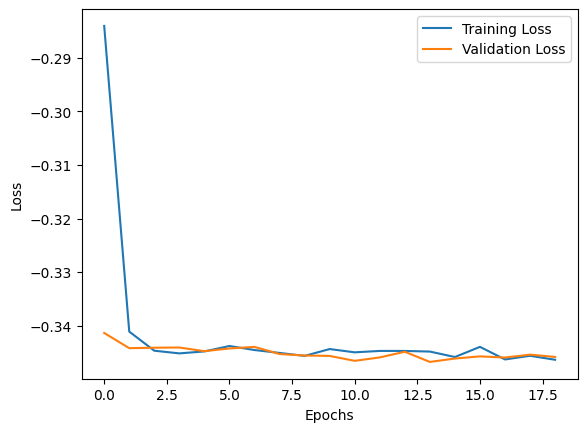

yay
Epoch 1/50
23/23 [==============================] - 5s 239ms/step - loss: -0.3466 - pearson_metric: 0.3466 - val_loss: -0.3370 - val_pearson_metric: 0.3370
Epoch 2/50
23/23 [==============================] - 2s 88ms/step - loss: -0.3464 - pearson_metric: 0.3464 - val_loss: -0.3419 - val_pearson_metric: 0.3419
Epoch 3/50
23/23 [==============================] - 1s 63ms/step - loss: -0.3473 - pearson_metric: 0.3473 - val_loss: -0.3397 - val_pearson_metric: 0.3397
Epoch 4/50
23/23 [==============================] - 1s 64ms/step - loss: -0.3472 - pearson_metric: 0.3472 - val_loss: -0.3410 - val_pearson_metric: 0.3410
Epoch 5/50
23/23 [==============================] - 1s 63ms/step - loss: -0.3468 - pearson_metric: 0.3468 - val_loss: -0.3387 - val_pearson_metric: 0.3387
Epoch 6/50
23/23 [==============================] - 1s 65ms/step - loss: -0.3464 - pearson_metric: 0.3464 - val_loss: -0.3396 - val_pearson_metric: 0.3396
Epoch 7/50
6/6 [==============================] - 0s 22ms/step
sc

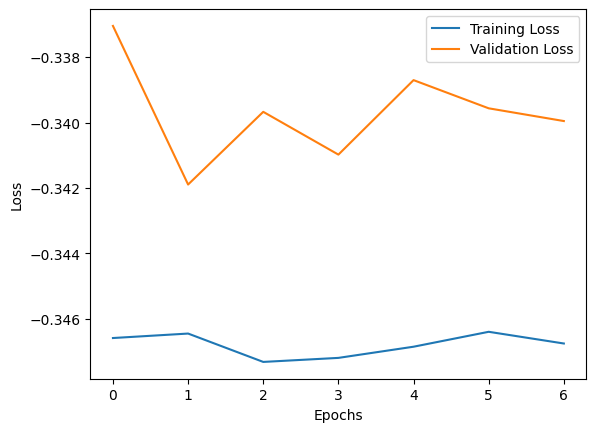

yay
Epoch 1/50
23/23 [==============================] - 4s 181ms/step - loss: -0.3447 - pearson_metric: 0.3447 - val_loss: -0.3499 - val_pearson_metric: 0.3499
Epoch 2/50
23/23 [==============================] - 2s 100ms/step - loss: -0.3442 - pearson_metric: 0.3442 - val_loss: -0.3496 - val_pearson_metric: 0.3496
Epoch 3/50
23/23 [==============================] - 2s 96ms/step - loss: -0.3446 - pearson_metric: 0.3446 - val_loss: -0.3514 - val_pearson_metric: 0.3514
Epoch 4/50
23/23 [==============================] - 1s 64ms/step - loss: -0.3461 - pearson_metric: 0.3461 - val_loss: -0.3494 - val_pearson_metric: 0.3494
Epoch 5/50
23/23 [==============================] - 1s 65ms/step - loss: -0.3463 - pearson_metric: 0.3463 - val_loss: -0.3497 - val_pearson_metric: 0.3497
Epoch 6/50
23/23 [==============================] - 2s 67ms/step - loss: -0.3465 - pearson_metric: 0.3465 - val_loss: -0.3488 - val_pearson_metric: 0.3488
Epoch 7/50
23/23 [==============================] - 1s 61ms/step

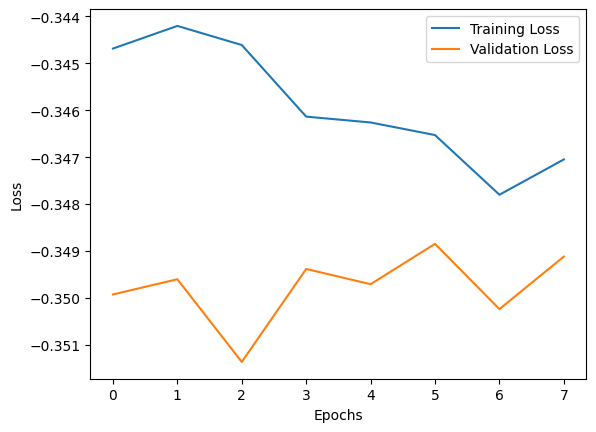

yay
Epoch 1/50
23/23 [==============================] - 4s 200ms/step - loss: -0.3468 - pearson_metric: 0.3468 - val_loss: -0.3461 - val_pearson_metric: 0.3461
Epoch 2/50
23/23 [==============================] - 2s 102ms/step - loss: -0.3471 - pearson_metric: 0.3471 - val_loss: -0.3446 - val_pearson_metric: 0.3446
Epoch 3/50
23/23 [==============================] - 1s 62ms/step - loss: -0.3472 - pearson_metric: 0.3472 - val_loss: -0.3447 - val_pearson_metric: 0.3447
Epoch 4/50
23/23 [==============================] - 2s 71ms/step - loss: -0.3472 - pearson_metric: 0.3472 - val_loss: -0.3471 - val_pearson_metric: 0.3471
Epoch 5/50
23/23 [==============================] - 2s 66ms/step - loss: -0.3490 - pearson_metric: 0.3490 - val_loss: -0.3471 - val_pearson_metric: 0.3471
Epoch 6/50
23/23 [==============================] - 1s 62ms/step - loss: -0.3498 - pearson_metric: 0.3498 - val_loss: -0.3449 - val_pearson_metric: 0.3449
Epoch 7/50
23/23 [==============================] - 2s 68ms/step

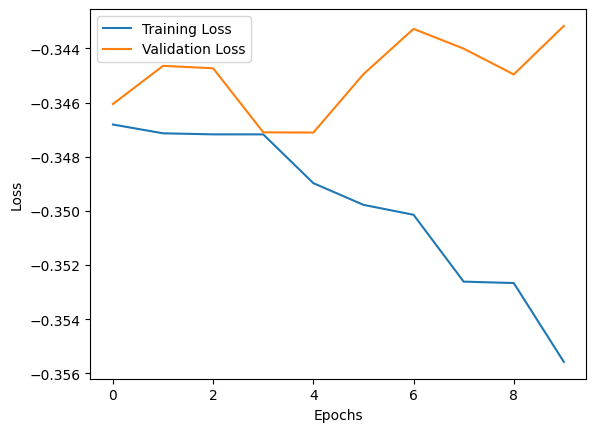

yay
Epoch 1/50
23/23 [==============================] - 5s 237ms/step - loss: -0.3490 - pearson_metric: 0.3490 - val_loss: -0.3506 - val_pearson_metric: 0.3506
Epoch 2/50
23/23 [==============================] - 2s 66ms/step - loss: -0.3499 - pearson_metric: 0.3499 - val_loss: -0.3462 - val_pearson_metric: 0.3462
Epoch 3/50
23/23 [==============================] - 1s 65ms/step - loss: -0.3496 - pearson_metric: 0.3496 - val_loss: -0.3492 - val_pearson_metric: 0.3492
Epoch 4/50
23/23 [==============================] - 2s 65ms/step - loss: -0.3530 - pearson_metric: 0.3530 - val_loss: -0.3471 - val_pearson_metric: 0.3471
Epoch 5/50
23/23 [==============================] - 2s 66ms/step - loss: -0.3541 - pearson_metric: 0.3541 - val_loss: -0.3401 - val_pearson_metric: 0.3401
Epoch 6/50
6/6 [==============================] - 0s 24ms/step
scores-> [0.2443625109498028, 0.2601483095584054, 0.26712435223381203, 0.2799951560383678, 0.24714178952990154]
scores_shuffled-> [0.2443993223568448, 0.2601

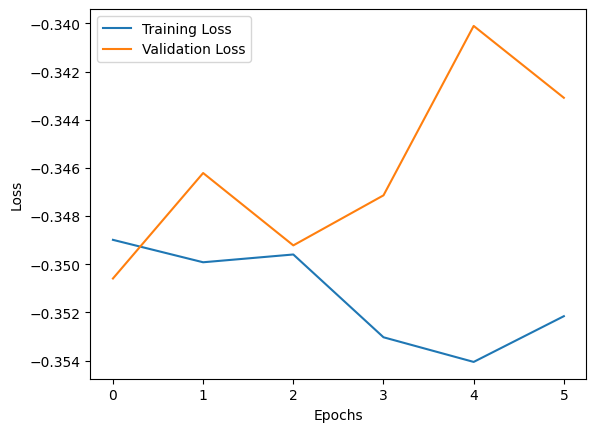

Average Accuracy: 0.2597544236620579


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Sample data and labels
# Your feature data (X) and target labels (y)
X = EEG_features_constrained  # Your feature matrix (e.g., NumPy array or Pandas DataFrame)
y = mega_audio_list # Your target labels (e.g., NumPy array or Pandas Series)
# Define the number of folds (K)
k = 5

# Initialize the KFold cross-validator
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize a list to store evaluation scores
scores = []
scores_shuffled = []

count=1
for train_index, val_index in kf.split(X):
    X_train=[]
    y_train=[]
    X_val=[]
    y_val=[]
    y_val_shuffled = []
    for i in train_index:
      X_train.append(X[i])
      y_train.append(y[i])

    for i in val_index:
      X_val.append(X[i])
      y_val.append(y[i])

    # Shuffle the list in-place
    y_val_shuffled = y_val.copy()
    random.shuffle(y_val_shuffled)

    if(y_val == y_val_shuffled ):
      print("Same - abort abort")
    else:
      print("yay")

    # X_train, X_val = X[train_index], X[val_index]
    # y_train, y_val = y[train_index], y[val_index]
    # Train your model on X_train and y_train
    results_folder="/content/drive/MyDrive/CAPSTONE_626_645_648_651/Code/Reconstruction/Model/cnn/SCE_adam_50epochs_32batch_size"
    model_path=results_folder+ f'/model_{count}.h5'
    epochs=50
    batch_size=32
    patience=5
    training_log_filename= f'training_log_{count}.csv'

    history=cnn_model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True),
            tf.keras.callbacks.CSVLogger(os.path.join(results_folder, training_log_filename)),
            tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True),
        ],
        )
    count+=1

    # Make predictions on X_val
    y_pred = cnn_model.predict(X_val)



    # Evaluate the model and store the score
    score = pearson_correlation(y_val, y_pred)
    scores.append(score)

    print("scores->",scores)

    # Evaluate the model and store the score
    score_shuffled = pearson_correlation(y_val_shuffled, y_pred)
    scores_shuffled.append(score_shuffled)
    print("scores_shuffled->",scores_shuffled)

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Calculate the average score
average_score = sum(scores) / len(scores)
average_score_shuffled = sum(score_shuffled) / len(score_shuffled)

print("Average Accuracy:", average_score)
print("Average Accuracy shuffled:", average_score_shuffled)



In [ ]:
scores

[0.2443625109498028,
 0.2601483095584054,
 0.26712435223381203,
 0.2799951560383678,
 0.24714178952990154]

In [ ]:
scores_shuffled

[0.2443993223568448,
 0.2601388835775785,
 0.26652827409569413,
 0.2765344991656574,
 0.24164562186825048]

In [ ]:
mean_scores = np.array(scores).mean()
std_scores = np.array(scores).std()
print(f"Mean Accuracy: {mean_scores:.2f}​​")
print(f"Standard Deviation: {std_scores:.2f}​​")

Mean Accuracy: 0.26​​
Standard Deviation: 0.01​​


In [ ]:
mean_scores = np.array(scores_shuffled).mean()
std_scores = np.array(scores_shuffled).std()
print(f"Mean Accuracy: {mean_scores:.2f}​​")
print(f"Standard Deviation: {std_scores:.2f}​​")

Mean Accuracy: 0.26​​
Standard Deviation: 0.01​​
